# Trying our different learning rate schedules

Using the default network configuration, the goal is to get to the reference valid loss as quickly as possible.

1. Typical learning rate decau
2. One cycle LR

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from src.score import *
from src.train_nn import *
import matplotlib.pyplot as plt

/home/stephan/miniconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/stephan/miniconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/stephan/miniconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/stephan/miniconda3/lib/python3.6/site-packages/tensorflow/python/frame

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"]=str(3)
limit_mem()

In [4]:
datadir = '/data/stephan/WeatherBench/5.625deg/'
var_dict = {'geopotential': ('z', [500]), 'temperature': ('t', [850])}
output_vars = None
filters = [64, 64, 64, 64, 2]
kernels = [5, 5, 5, 5, 5]
lead_time = 72
batch_size = 128
activation = 'elu'

In [8]:
ds = xr.merge([xr.open_mfdataset(f'{datadir}/{var}/*.nc', combine='by_coords') for var in var_dict.keys()])

In [9]:
ds_train = ds.sel(time=slice('1979', '2015'))
ds_valid = ds.sel(time=slice('2016', '2016'))
ds_test = ds.sel(time=slice('2017', '2018'))

In [12]:
dg_train = DataGenerator(ds_train, var_dict, lead_time, batch_size=batch_size, output_vars=output_vars)
dg_valid = DataGenerator(ds_valid, var_dict, lead_time, batch_size=batch_size, mean=dg_train.mean,
                         std=dg_train.std, shuffle=False, output_vars=output_vars)
dg_test =  DataGenerator(ds_test, var_dict, lead_time, batch_size=batch_size, mean=dg_train.mean,
                         std=dg_train.std, shuffle=False, output_vars=output_vars)
print(f'Mean = {dg_train.mean}; Std = {dg_train.std}')

DG start 15:02:56.770293
DG normalize 15:02:56.788158


KeyboardInterrupt: 

In [ ]:
model = build_cnn(filters, kernels, input_shape=(32, 64, len(dg_train.data.level)), activation=activation)
model.compile(keras.optimizers.Adam(lr), 'mse')

## Learning rate decay

In [13]:
class LRUpdate(object):
    def __init__(self, init_lr, step, divide):
        # From goo.gl/GXQaK6
        self.init_lr = init_lr
        self.step = step
        self.drop = 1. / divide

    def __call__(self, epoch):
        lr = self.init_lr * np.power(self.drop, np.floor((epoch) / self.step))
        print(f'Learning rate = {lr}')
        return lr

In [14]:
lrs = LRUpdate(1e-3, 2, 5)

Learning rate = [1.0e-03 1.0e-03 2.0e-04 2.0e-04 4.0e-05 4.0e-05 8.0e-06 8.0e-06 1.6e-06
 1.6e-06]


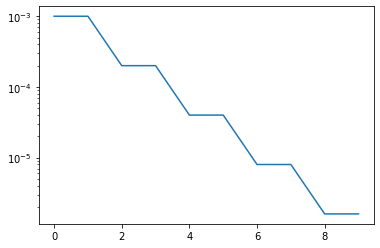

In [19]:
plt.plot(lrs(np.arange(10)))
plt.yscale('log')

## One Cycle

In [6]:
from src.clr import LRFinder